> Try to divide train and test(GNAR fivenet)

In [1]:
def vis(STdata):
    N = STdata.shape[1]
    fig, ax = plt.subplots(5,1,(15,5))
    for n in range(N):
        ax[n].plot(fiveVTS[:,0])
    #fig.set_width()
    fig.set_height(N*5) 
    return fig 

# import

In [5]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

In [6]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [7]:
#%load_ext rpy2.ipython

In [8]:
#%%R
#library(GNAR)
#library(igraph)

# Data

In [9]:
#%%R
#summary(fiveNet)

In [10]:
#%%R
#edges <- as.matrix(fiveNet)
#data("fiveNode")

In [11]:
#%R -o fiveVTS
#%R -o edges

- node: 5
- time 200

# functions 

In [12]:
def vis(spatiotemporaldata):
    N = spatiotemporaldata.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata[:,n])
        ax[n].set_title('node='+str(n))
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [13]:
def vis2(spatiotemporaldata1,spatiotemporaldata2):
    N = spatiotemporaldata1.shape[1]
    fig, ax = plt.subplots(N,1)
    for n in range(N):
        ax[n].plot(spatiotemporaldata1[:,n],label='data1')
        ax[n].plot(spatiotemporaldata2[:,n],label='data2')
        ax[n].set_title('node='+str(n))
        ax[n].legend()
    #fig.set_width()
    fig.set_figheight(N*2) 
    fig.tight_layout()
    return fig 

In [19]:
df =pd.read_csv("https://raw.githubusercontent.com/seoyeonc/blog/main/posts/GCN/fiveVTS.csv")
fiveVTS = torch.tensor(np.array(df.iloc[:,1:]))

In [20]:
edges = np.array(pd.read_csv("https://raw.githubusercontent.com/seoyeonc/blog/main/posts/GCN/edges.csv").iloc[:,1:])
edges

array([[0, 0, 0, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0]])

In [21]:
edges_tensor = torch.tensor(edges)

In [22]:
nonzero_indices = edges_tensor.nonzero()

In [23]:
fiveNet_edge = np.array(nonzero_indices).T

In [24]:
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1

In [25]:
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

In [26]:
fiveVTS.shape

torch.Size([200, 5])

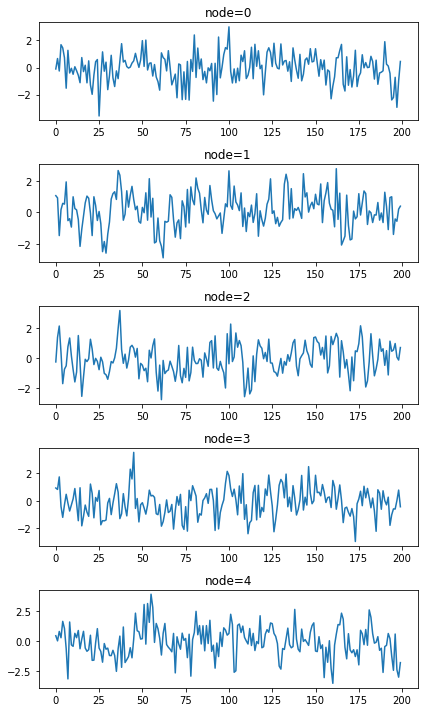

In [27]:
vis(fiveVTS);

In [28]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

In [29]:
fiveVTS_train.shape, fiveVTS_test.shape

(torch.Size([160, 5]), torch.Size([40, 5]))

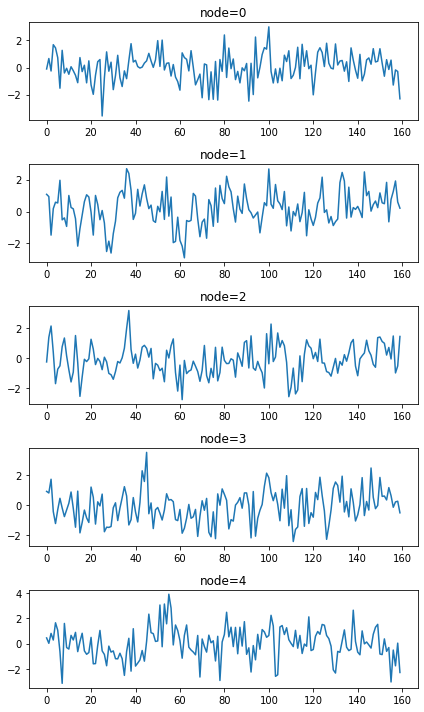

In [30]:
vis(fiveVTS_train);

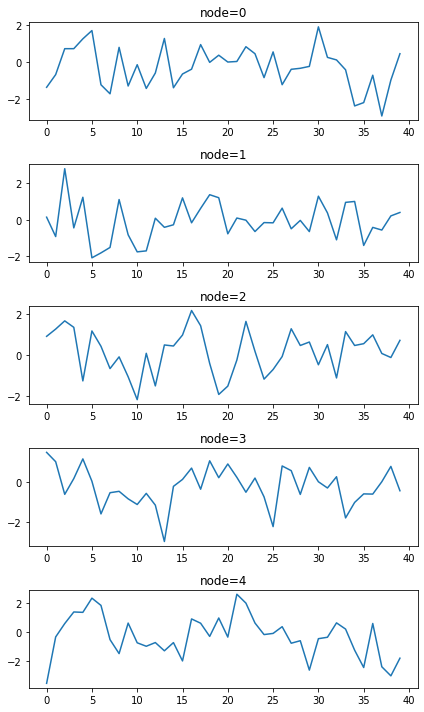

In [31]:
vis(fiveVTS_test);

# Randomly Missing Values

In [32]:
np.random.seed(1)
seed_number1 = np.random.choice(160,80,replace=False)

In [33]:
np.random.seed(3)
seed_number2 = np.random.choice(160,80,replace=False)

In [34]:
np.random.seed(5)
seed_number3 = np.random.choice(160,80,replace=False)

In [35]:
np.random.seed(7)
seed_number4 = np.random.choice(160,80,replace=False)

In [36]:
np.random.seed(9)
seed_number5 = np.random.choice(160,80,replace=False)

In [37]:
fiveVTS_train[seed_number1,0] = float('nan')

In [38]:
fiveVTS_train[seed_number2,1] = float('nan')

In [39]:
fiveVTS_train[seed_number3,2] = float('nan')

In [40]:
fiveVTS_train[seed_number4,3] = float('nan')

In [41]:
fiveVTS_train[seed_number5,4] = float('nan')

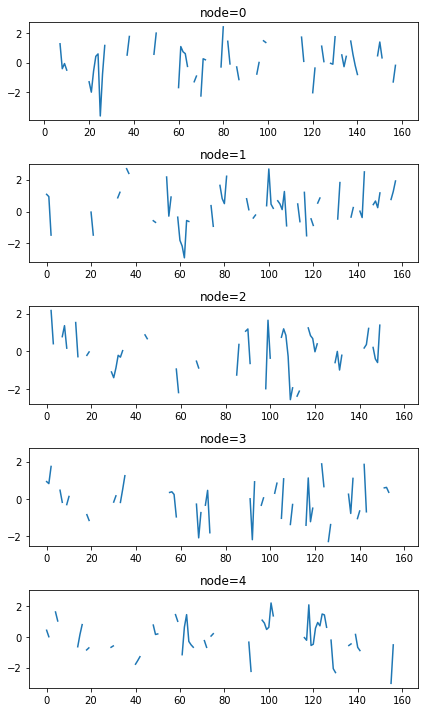

In [42]:
vis(fiveVTS_train);

# 1. Mean

In [43]:
fiveVTS_train_mean = fiveVTS_train.clone()

In [44]:
fiveVTS_train_mean[seed_number1,0] = np.nanmean(fiveVTS_train_mean[:,0])

In [45]:
fiveVTS_train_mean[seed_number2,1] = np.nanmean(fiveVTS_train_mean[:,1])

In [46]:
fiveVTS_train_mean[seed_number3,2] = np.nanmean(fiveVTS_train_mean[:,2])

In [47]:
fiveVTS_train_mean[seed_number4,3] = np.nanmean(fiveVTS_train_mean[:,3])

In [48]:
fiveVTS_train_mean[seed_number5,4] = np.nanmean(fiveVTS_train_mean[:,4])

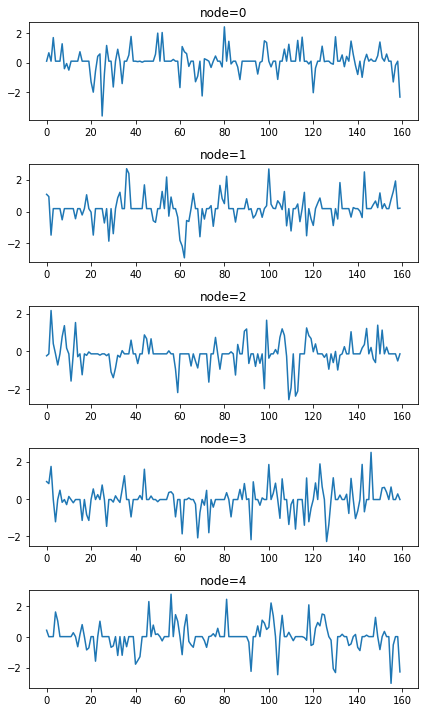

In [49]:
vis(fiveVTS_train_mean);

## 1) ST-GCN

In [50]:
mean_f_fiveVTS_train = torch.tensor(fiveVTS_train_mean).reshape(160,5,1).float()

/home/cgb4/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [51]:
mean_X_fiveVTS = mean_f_fiveVTS_train[:159,:,:]
mean_y_fiveVTS = mean_f_fiveVTS_train[1:,:,:]

In [52]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_fiveVTS,mean_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


In [53]:
mean_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_fiveVTS]).detach().numpy()

In [54]:
fiveVTS_test.float()

tensor([[-1.3798,  0.1459,  0.9158,  1.4848, -3.5004],
        [-0.6878, -0.9167,  1.2704,  1.0167, -0.3307],
        [ 0.7200,  2.8028,  1.6711, -0.6230,  0.5819],
        [ 0.7209, -0.4410,  1.3555,  0.1693,  1.3739],
        [ 1.2559,  1.2374, -1.2614,  1.1569,  1.3480],
        [ 1.7057, -2.0821,  1.1786,  0.0351,  2.3181],
        [-1.2413, -1.8109,  0.4296, -1.6056,  1.8224],
        [-1.7336, -1.5126, -0.6606, -0.5410, -0.5155],
        [ 0.7925,  1.1118, -0.0874, -0.4713, -1.4689],
        [-1.3085, -0.8209, -1.0603, -0.8488,  0.6158],
        [-0.1514, -1.7553, -2.1784, -1.1333, -0.7315],
        [-1.4409, -1.7015,  0.0866, -0.5748, -0.9676],
        [-0.6027,  0.0888, -1.5058, -1.1654, -0.7148],
        [ 1.2753, -0.4101,  0.4946, -2.9917, -1.2779],
        [-1.4045, -0.2712,  0.4429, -0.2222, -0.7184],
        [-0.6562,  1.2038,  0.9780,  0.1263, -1.9698],
        [-0.3942, -0.1619,  2.1763,  0.6952,  0.8985],
        [ 0.9426,  0.6274,  1.4339, -0.3655,  0.6060],
        [-

In [62]:
xt_test = fiveVTS_test.float().reshape(40,5,1)[:-1,:,:]

In [63]:
mean_fhat_fiveVTS_forecast = torch.stack([model(xt, edge_index, edge_attr) for xt in xt_test]).detach().numpy()

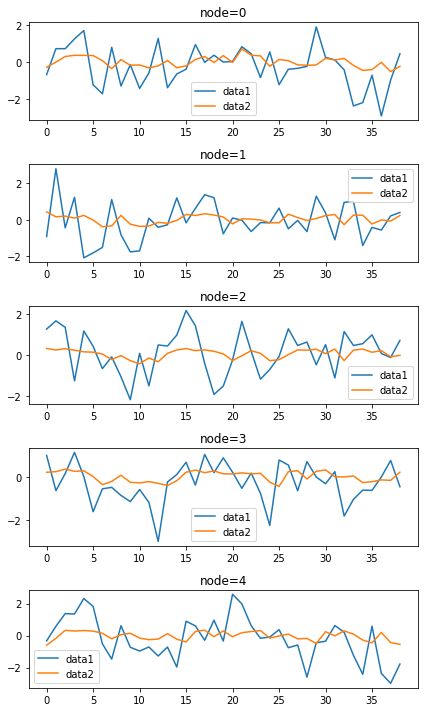

In [65]:
vis2(fiveVTS_test[1:],mean_fhat_fiveVTS_forecast);

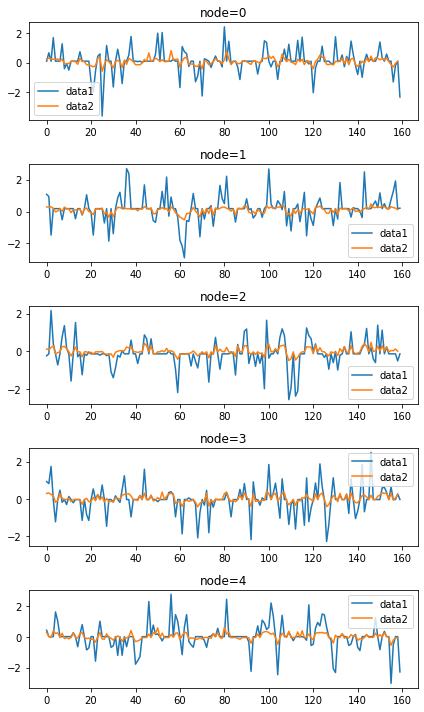

In [66]:
vis2(fiveVTS_train_mean,mean_fhat_fiveVTS);

---

## 2) Fourier transform

In [164]:
w=np.zeros((159*N,159*N))

In [165]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [143]:
# #w= edges
# d = np.array(w.sum(axis=1))
# L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
# lamb, Psi = np.linalg.eigh(L)
# Lamb = np.diag(lamb)

In [139]:
# np.fft(mean_fhat_fiveVTS[:,0,0])

In [140]:
# mean_fhat_fiveVTS.shape

In [141]:
# fft_result =np.stack([np.fft.fft(mean_fhat_fiveVTS[:,n,0]) for n in range(N)]).T

In [142]:
# plt.plot(abs(fft_result[:,0])**2)

In [193]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)

In [212]:
fhatbar = Psi.T @ mean_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

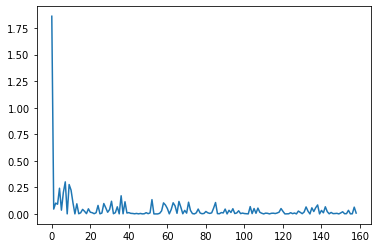

In [223]:
plt.plot(fhatbar.reshape(159,5)[:,0]**2)

In [225]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

NotImplementedError: Conversion 'rpy2py' not defined for objects of type '<class 'rpy2.rinterface_lib.sexp.SexpEnvironment'>'

In [215]:
#plt.plot(power_threshed.reshape(159,5)[:,0])

## 4) Inverse Fourier transform

In [216]:
mean_fhat_fiveVTS.reshape(159*N,1)[:5]

array([[0.23813698],
       [0.28354457],
       [0.12005569],
       [0.30111006],
       [0.2924315 ]], dtype=float32)

In [217]:
(Psi @ fhatbar)[:5]

array([[0.23813698],
       [0.28354457],
       [0.12005569],
       [0.30111006],
       [0.2924315 ]])

In [220]:
# fhatbarhat = Psi @ fhatbar_threshed
# fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

fhatbarhat = Psi @ fhatbar
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1) #fhatbarhat.reshape(159,N,1)

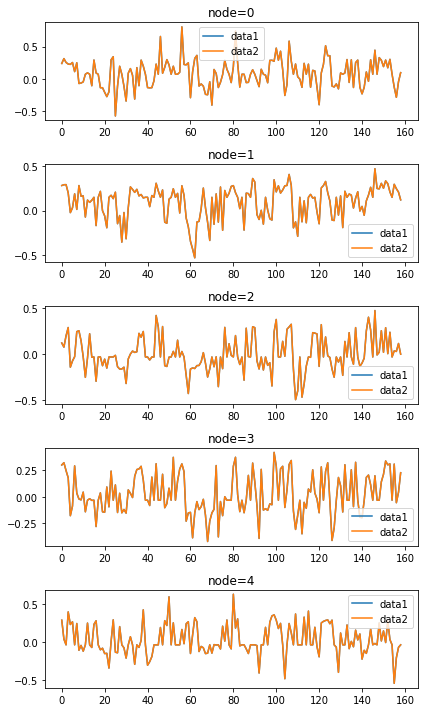

In [222]:
vis2(mean_fhat_fiveVTS,fhatbarhat_mean_spatio_temporal.reshape(159,5));

## 5) ST-GCN

In [ ]:
mean_spatio_temporal = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [ ]:
mean_X_spatio_temporal = mean_spatio_temporal[:158,:,:]
mean_y_spatio_temporal = mean_spatio_temporal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal,mean_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
mean_X_spatio_temporal_fore = mean_spatio_temporal[119:,:,:]

In [ ]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal_fore]).detach().numpy()

### Box plot

In [ ]:
sum((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)**2)

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 6) Fourier transform

In [ ]:
mean_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_spatio_temporal]).detach().numpy()

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ mean_fhat_spatio_temporal.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 8) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_mean_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 9) ST-GCN

In [ ]:
mean_spatio_temporal2 = torch.tensor(fhatbarhat_mean_spatio_temporal).reshape(159,5,1).float()

In [ ]:
mean_X_spatio_temporal2 = mean_spatio_temporal2[:158,:,:]
mean_y_spatio_temporal2 = mean_spatio_temporal2[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(mean_X_spatio_temporal2,mean_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
mean_X_spatio_temporal_fore2 = mean_spatio_temporal2[119:,:,:]

In [ ]:
mean_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in mean_X_spatio_temporal_fore2]).detach().numpy()

### Box plot

In [ ]:
sum((mean_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)**2)

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((mean_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((mean_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

# 2. Linear Interpolation

In [ ]:
_df = pd.DataFrame(fiveVTS_train)
_df.interpolate(method='linear', inplace=True)
_df = _df.fillna(0)

In [ ]:
linear_fiveVTS_train = np.array(_df).reshape(160,5)

## 1) ST-GCN

In [ ]:
linear_f_fiveVTS_train = torch.tensor(linear_fiveVTS_train).reshape(160,5,1).float()

In [ ]:
linear_X_fiveVTS = linear_f_fiveVTS_train[:159,:,:]
linear_y_fiveVTS = linear_f_fiveVTS_train[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_fiveVTS,linear_y_fiveVTS)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_fhat_fiveVTS = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_fiveVTS]).detach().numpy()

## 2) Fourier transform

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 3) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 4) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 5) ST-GCN

In [ ]:
linear_spatio_temporal = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [ ]:
linear_X_spatio_temporal = linear_spatio_temporal[:158,:,:]
linear_y_spatio_temporal = linear_spatio_temporal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal,linear_y_spatio_temporal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

---

In [ ]:
linear_X_spatio_temporal_fore = linear_spatio_temporal[119:,:,:]

In [ ]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore]).detach().numpy()

### Box plot

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

## 6) Fourier transform

In [ ]:
linear_fhat_spatio_temporal = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_spatio_temporal]).detach().numpy()

In [ ]:
w=np.zeros((159*N,159*N))

In [ ]:
for i in range(159*N):
    for j in range(159*N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ linear_fhat_fiveVTS.reshape(159*N,1)
power = fhatbar**2 

## 7) Ebayes

In [ ]:
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(159*N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)

## 8) Inverse Fourier transform

In [ ]:
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_linear_spatio_temporal = fhatbarhat.reshape(159,N,1)

## 9) ST-GCN

In [ ]:
linear_spatio_temporal2 = torch.tensor(fhatbarhat_linear_spatio_temporal).reshape(159,5,1).float()

In [ ]:
linear_X_spatio_temporal2 = linear_spatio_temporal2[:158,:,:]
linear_y_spatio_temporal2 = linear_spatio_temporal2[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(linear_X_spatio_temporal2,linear_y_spatio_temporal2)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
linear_X_spatio_temporal_fore2 = linear_spatio_temporal2[119:,:,:]

In [ ]:
linear_fhat_spatio_temporal2 = torch.stack([model(xt, edge_index, edge_attr) for xt in linear_X_spatio_temporal_fore2]).detach().numpy()

### Box plot

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((linear_fhat_spatio_temporal2.reshape(40,5) -  fiveVTS_test)).reshape(200,1))

# 3. GNAR

**mean**

In [ ]:
%R -i fiveVTS_train_mean

In [ ]:
%%R
meanprediction <- predict(GNARfit(vts = fiveVTS_train_mean[1:160,], net = fiveNet, alphaOrder = 2, betaOrder = c(1, 1)),n.ahead=40)

In [ ]:
%R -o meanprediction

In [ ]:
sum((meanprediction.reshape(40,5)[1] -  fiveVTS_test[1])**2)

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot((meanprediction.reshape(40,5) -  fiveVTS_test))

In [ ]:
plt.figure(figsize=(20, 8))
plt.boxplot(((meanprediction.reshape(40,5) -  fiveVTS_test)).reshape(200,1))